In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
import matplotlib.pyplot as plt
import sys

In [2]:
## pick a frame that will be used as the allignment template
## Export to pdb using VMD or whatever software you want
ref = mda.Universe('pdbs/reference.pdb')

## no need to touch these lines unless you want to align on something other than CA
## If you change, be sure to change the rest of the script too
protein = ref.select_atoms("name CA")
ref_resids = protein.resids

/home/agp2004/anaconda3/envs/tica_env/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "


In [3]:
## Step1: get all xyz coordinates from all trajectories

trajes = []

### You may need to customize this for loop to reflect your file structure ######
for lig in ["4CT2", "5HT", "6FDMT", "DMT", "DOI", "ERG", "KET", "LIS", "LSD", "MES"]:
    for i in range(6):
        psf = lig + '/' + str(i) + '/ionized.wrapped.psf'
        traj = lig + '/' + str(i) + '/' + lig + '_' + str(i) + '_small.xtc'
#################################################################################
        
        try:
            mobile = mda.Universe(psf, traj)
        except:
            continue
        print(lig, i)
        
        # Extract C-alpha coordinates
        # ---------
        temp=[]
        protein = mobile.select_atoms("name CA")
        for ts in mobile.trajectory:
            temp.append(protein.positions)

        temp = np.asarray(temp)
        # ---------
        
        if not np.array_equal(protein.resids,ref_resids):
            raise Exception('error in resids')
        
        if len(trajes)>3:
            np.vstack((trajes, temp))
        else:
            trajes = temp

4CT2 0
4CT2 1
4CT2 2
4CT2 3
4CT2 4
4CT2 5
5HT 0
5HT 1
5HT 2
5HT 3
5HT 4
6FDMT 0
6FDMT 2
6FDMT 3
6FDMT 5
DMT 0
DMT 1
DMT 2
DMT 3
DMT 4
DMT 5
DOI 0
DOI 1
DOI 2
DOI 3
DOI 4
DOI 5
ERG 0
ERG 1
ERG 2
ERG 3
ERG 4
ERG 5
KET 0
KET 1
KET 2
KET 3
KET 4
KET 5
LIS 0
LIS 2
LIS 3
LIS 5
LSD 0
LSD 1
LSD 2
LSD 4
LSD 5
MES 0
MES 1
MES 2
MES 3
MES 4
MES 5


In [4]:
# Step2: Calculate all c-alpha distances

# ---------
from itertools import combinations
Calphas = np.array(list(range(trajes.shape[1])))
pairs = list(combinations(Calphas,2))

dist_mat = np.array([np.linalg.norm((trajes[:,pair[0],:]-trajes[:,pair[1],:]), axis=1) for pair in pairs])
pairs = np.asarray(pairs)
# ---------

# Step3: Calculate mean standard deviation for each residue
# ---------
stds=[]
for i in Calphas:
    stds.append(np.std(dist_mat[np.where((pairs[:,1]==i) | (pairs[:,0]==i))[0]], axis=1).mean())
stds = np.asarray(stds)
# ---------

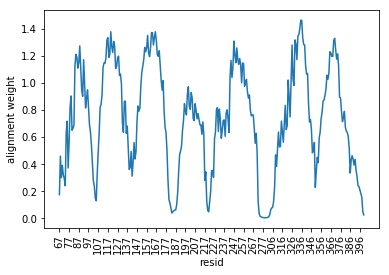

In [15]:
plt.plot(1/stds**3) ## make the exponent larger for sharper weight distribution
plt.xticks(list(np.arange(0,protein.resids.shape[0],10)), protein.resids[::10], rotation='vertical');
plt.xlabel('resid')
plt.ylabel('alignment weight')
# plt.savefig('alignment_plot.png', dpi=300)

In [21]:
# Step4: Align and write trajectory files

## Use the same for loop as in step1, but add out_dcd #########
for lig in ["4CT2", "5HT", "6FDMT", "DMT", "DOI", "ERG", "KET", "LIS", "LSD", "MES"]:
    for i in range(6):
        psf = lig + '/' + str(i) + '/ionized.wrapped.psf'
        traj = lig + '/' + str(i) + '/' + lig + '_' + str(i) + '_small.xtc'
        out_dcd = lig + '/' + str(i) + '/' + lig + '_' + str(i) + '_small_aligned.dcd'
###############################################

        try:
            mobile = mda.Universe(psf, traj)
        except:
            continue
        print(lig, i)

        mobile.trajectory[-1]  # set mobile trajectory to last frame

        # Align using the inverse of the standard deviation as weights
        aligner = align.AlignTraj(mobile, ref, select='name CA', weights=(1/stds**3), filename=out_dcd).run()

4CT2 0
4CT2 1
4CT2 2
4CT2 3
4CT2 4
4CT2 5
5HT 0
5HT 1
5HT 2
5HT 3
5HT 4
6FDMT 0
6FDMT 2
6FDMT 3
6FDMT 5
DMT 0
DMT 1
DMT 2
DMT 3
DMT 4
DMT 5
DOI 0
DOI 1
DOI 2
DOI 3
DOI 4
DOI 5
ERG 0
ERG 1
ERG 2
ERG 3
ERG 4
ERG 5
KET 0
KET 1
KET 2
KET 3
KET 4
KET 5
LIS 0
LIS 2
LIS 3
LIS 5
LSD 0
LSD 1
LSD 2
LSD 4
LSD 5
MES 0
MES 1
MES 2
MES 3
MES 4
MES 5
